# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana.app", no_graphics=True)

# Select the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### Train a DQN
using simple Q-learning, defining Q to be a 3-layer NN

In [5]:
from dqn_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=0, ddqn=True)

Creating new Double DQN agent
Initializing replay buffer with buffer size 30000 and batch size 64 with gamma= 0.95


Episode 8	Eps: 0.384	Batch size: 64	Score: -3	Max Score: 3	Average Score Last 10: -0.12	Average Score Last 100: -0.12	
Episode 16	Eps: 0.369	Batch size: 64	Score: 4	Max Score: 7	Average Score Last 10: 2.10	Average Score Last 100: 1.4410	
Episode 24	Eps: 0.355	Batch size: 64	Score: 6	Max Score: 9	Average Score Last 10: 3.90	Average Score Last 100: 2.295	
Episode 33	Eps: 0.339	Batch size: 64	Score: 7	Max Score: 11	Average Score Last 10: 5.20	Average Score Last 100: 3.064	
Episode 41	Eps: 0.326	Batch size: 64	Score: 5	Max Score: 11	Average Score Last 10: 6.30	Average Score Last 100: 3.681	
Episode 49	Eps: 0.313	Batch size: 64	Score: 4	Max Score: 11	Average Score Last 10: 5.10	Average Score Last 100: 3.94	
Episode 58	Eps: 0.299	Batch size: 64	Score: 7	Max Score: 11	Average Score Last 10: 7.30	Average Score Last 100: 4.527	
Episode 66	Eps: 0.287	Batch size: 64	Score: 8	Max Score: 13	Average Score Last 10: 8.30	Average Score Last 100: 4.951	
Episode 74	Eps: 0.276	Batch size: 64	Score: 3	Max 

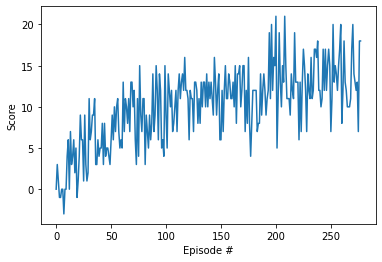

In [6]:
def dqn(n_episodes=500, max_t=310, eps_start=0.4, eps_end=0.01, eps_decay=0.995, update_target_every=2500, update_batch_every=50000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode (this env stops after 303 anyway)
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        update_target_every (int): number of training timesteps between updates to target Q network
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    scores_window_10 = deque(maxlen=10)  # last 10 scores
    eps = eps_start                    # initialize epsilon
    tt = 0
    max_score = -13
    for i_episode in range(1, n_episodes+1):
        state = env.reset(train_mode=True)[brain_name].vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            tt += 1
            if tt % update_target_every == 0: # or (tt < (2 * update_target_every) and tt % (update_target_every / 4) == 0):
                if not agent.ddqn:
                    print("\tUpdating target Q!")
                    agent.hard_update(tt % update_batch_every == 0)
                else:
                    print("\t")
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores_window_10.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        max_score = max(score, max_score)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tEps: {:.3f}\tBatch size: {:d}\tScore: {:d}\tMax Score: {:d}\tAverage Score Last 10: {:.2f}\tAverage Score Last 100: {:.2f}'.format(i_episode, eps, agent.batch_size, int(score), int(max_score), np.mean(scores_window_10), np.mean(scores_window)), end="")
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tEps: {:.3f}\tGamma: {:.2f}\tAverage Score: {:.2f}'.format(i_episode-100, eps, agent.gamma, np.mean(scores_window)))
            if not agent.ddqn:
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            else:
                torch.save(agent.qnetwork1.state_dict(), 'checkpoint_Q1.pth')
                torch.save(agent.qnetwork2.state_dict(), 'checkpoint_Q2.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
# 18 min for 500 episodes